In [1]:
from Data_Enrichment import get_features

RAW_DIR = "data/raw"
df_feats, feature_cols = get_features(RAW_DIR)
df_feats = df_feats[(df_feats['season_end_year'] != 2025) & (df_feats['season_end_year'] != 2026)]

/workspaces/Machine-learning/Data_Enrichment.py:300: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [3]:
# %% Selected minimal features (top 20)
selected_features = [
    'matches_played_z_lag1','a_per90_z_lag1','g_per90_z_lag1','ga_per90_z_lag1',
    'pen_share_z_lag1','g_per90_z_delta','a_per90_w','ga_per90_z_delta','g_per90_w',
    'a_per90_z_delta','ga_per90_w','main_position','pen_share_w','minutes_played_z_lag1',
    'minutes_played_z_delta','position','clean_sheet_rate_z_lag1','height','pen_share_z_delta',
    'matches_played_z_delta'
]

# Create dataframe with only selected features
df = df_feats[selected_features].copy()

In [4]:
# %% Separate numeric features and standardize
numeric_features = df.select_dtypes(include=np.number)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

# Quick check
pd.DataFrame(X_scaled, columns=numeric_features.columns).head()


,matches_played_z_lag1,a_per90_z_lag1,g_per90_z_lag1,ga_per90_z_lag1,pen_share_z_lag1,g_per90_z_delta,a_per90_w,ga_per90_z_delta,g_per90_w,a_per90_z_delta,ga_per90_w,pen_share_w,minutes_played_z_lag1,minutes_played_z_delta,clean_sheet_rate_z_lag1,height,pen_share_z_delta,matches_played_z_delta
0,-0.153307,-0.052433,-0.041087,-0.046569,-0.022538,-0.004796,1.736261,-0.006149,0.336199,-0.007492,0.789956,0.002756,-0.081352,-0.015089,-0.011092,-3.579418,-0.014083,-0.041743
1,-1.273548,0.890449,0.010572,0.335580,-0.263126,-0.342960,-0.877991,-0.737068,-0.174502,-1.267564,-0.402963,0.002756,-0.585542,-0.204825,-0.202561,-3.579418,0.000346,-0.311159
2,-1.515781,-0.367014,-0.319044,-0.357797,-0.245550,0.034024,-0.877991,0.048276,-0.174502,0.038198,-0.402963,0.002756,-0.790944,-0.023517,-0.200723,-3.579418,-0.013157,0.031657
3,-0.153307,-0.052433,-0.041087,-0.046569,-0.022538,-0.004796,-5.664896,-0.006149,-3.940588,-0.007492,-4.791521,-0.476726,-0.081352,-0.015089,-0.011092,0.311271,-0.014083,-0.041743
4,-1.757825,-0.376100,-0.391974,-0.406959,-0.270840,1.968158,-3.216035,1.837353,-1.070244,1.184538,-1.811657,-0.476726,-0.937633,0.412189,-0.216683,0.311271,-0.007750,2.925246


In [16]:
# %% KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=1, n_init=50)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['kmeans_cluster'] = labels.astype(str)


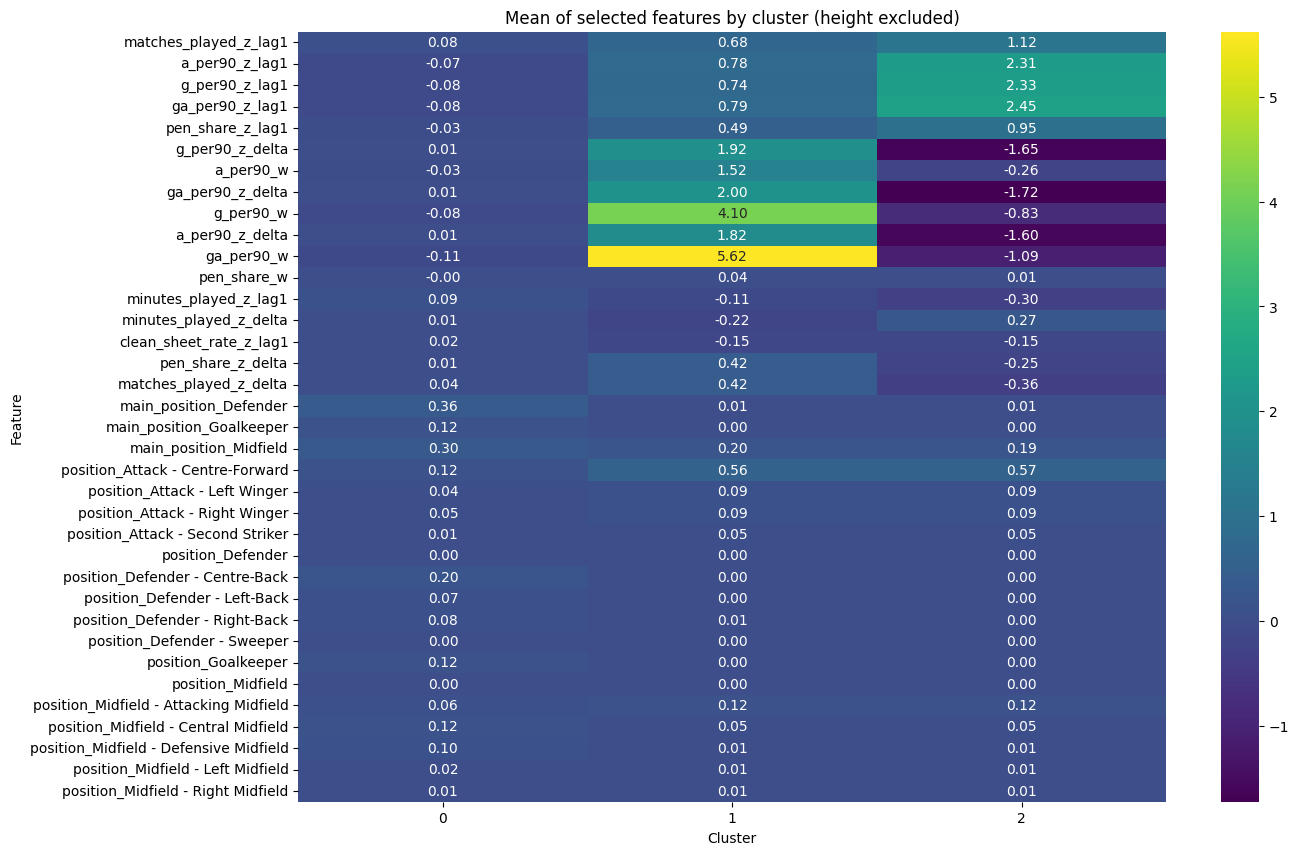

In [17]:
# %% Module 6 – Cluster Analysis (fixed, height removed)

# Exclude 'height' from numeric features
features_for_analysis = [f for f in df.columns if f != 'height' and f != 'kmeans_cluster']

# Encode categorical features
categorical_cols = ['main_position', 'position']
categorical_cols = [col for col in categorical_cols if col in features_for_analysis]

df_encoded = pd.get_dummies(df[features_for_analysis + ['kmeans_cluster']], 
                            columns=categorical_cols, drop_first=True)

# Compute cluster means (numeric + encoded categorical)
cluster_means = df_encoded.groupby('kmeans_cluster').mean().T

# Heatmap of features by cluster
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_means, annot=True, cmap='viridis', fmt=".2f")
plt.title('Mean of selected features by cluster (height excluded)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()



/tmp/ipykernel_24134/1069597892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


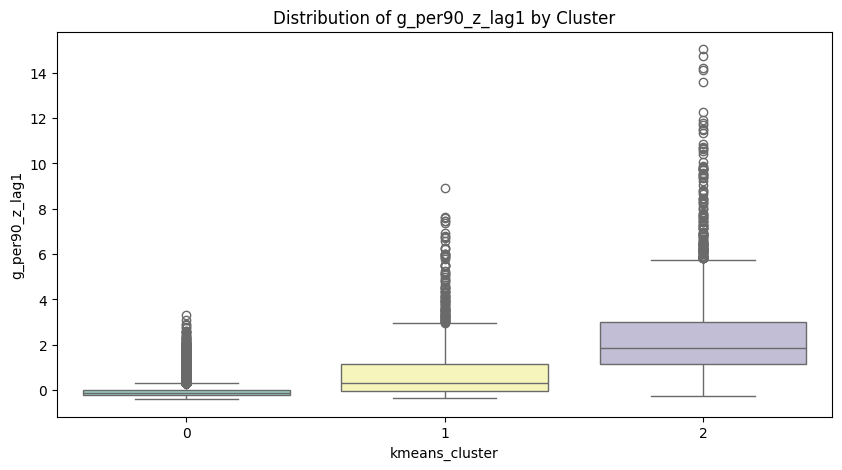

/tmp/ipykernel_24134/1069597892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


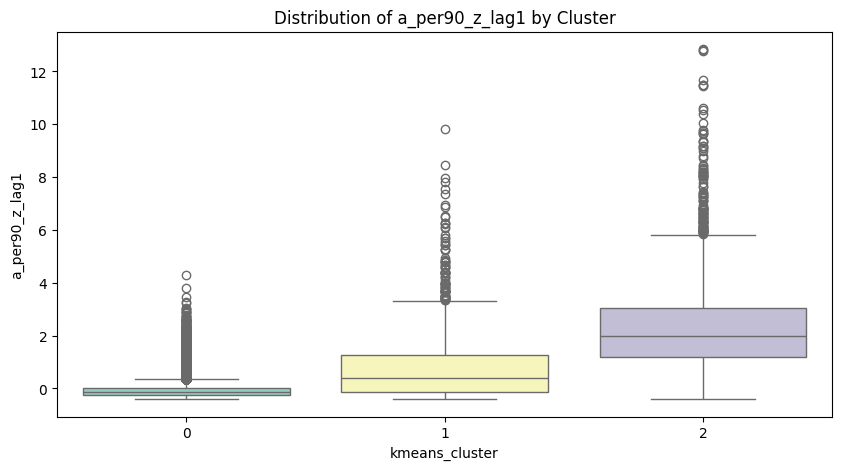

/tmp/ipykernel_24134/1069597892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')


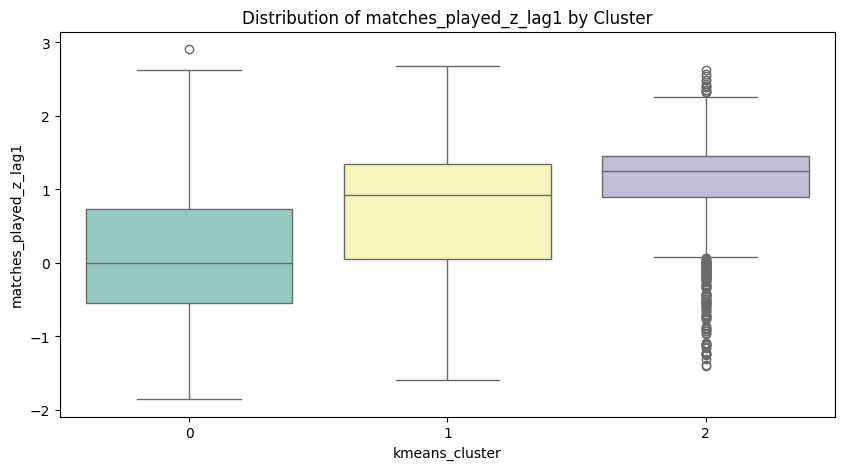

In [18]:
variables = ['g_per90_z_lag1', 'a_per90_z_lag1', 'matches_played_z_lag1']

for var in variables:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='kmeans_cluster', y=var, data=df, palette='Set3')
    plt.title(f'Distribution of {var} by Cluster')
    plt.show()


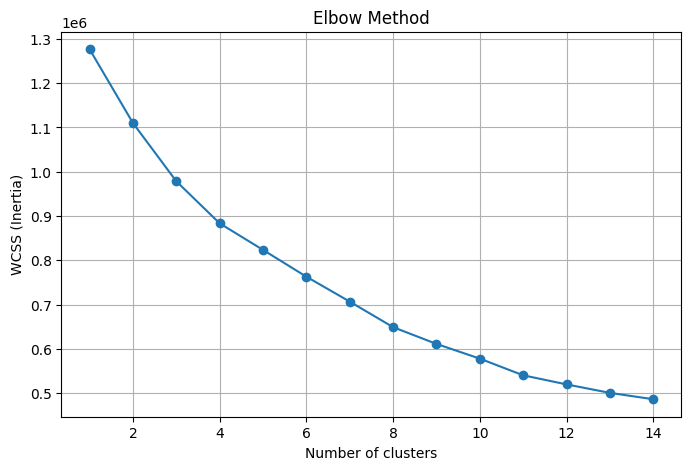

In [7]:
# %% Elbow method
wcss = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()


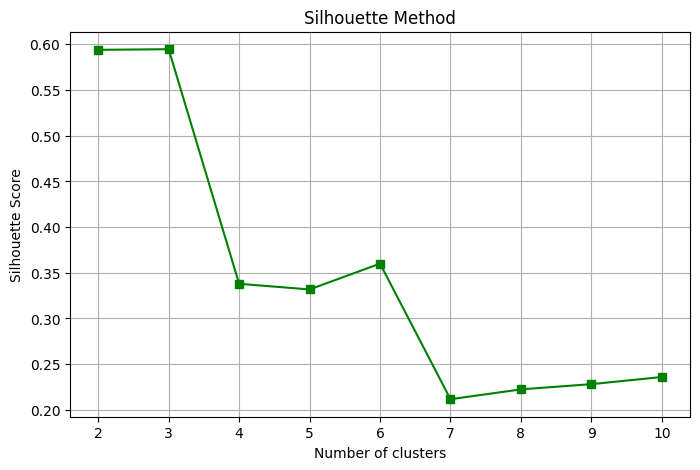

In [8]:
# %% Silhouette method
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='s', color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()
